# #

 # Automated Title Generation for Academic Papers through Natural Language Processing Techniques

# Model 1

In [17]:
import pandas as pd 
import numpy as np
import heapq

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt  


In [6]:
df = pd.read_csv('5-Minute Crafts.csv')
titles = df[['title']]
titles.head(12)

,title
0,SUPER LAZY LIFE HACKS || Cool Hacks To Make Yo...
1,YUM! EASY SMART FOOD HACKS || Tasty Recipes Fo...
2,HELPFUL LIFE HACKS FOR YOUR HOUSE
3,USEFUL HACKS FOR YOUR HOME || Simple Tips That...
4,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...
5,100+ HACKS & GADGETS FOR COOL PARENTS
6,30 BEST HACKS FOR EVERY LIFE SITUATION
7,KID'S ROOM MAKEOVER IDEAS || Awesome Home Deco...
8,Brilliant Clothing Hacks For Adults and Their ...
9,BRILLIANT LIFE HACKS FOR ANY SITUATION


In [7]:
separated_titles = titles['title'].str.replace('&', 'and').str.split(' \|\| ', expand=True)
cleaned_titles = separated_titles[[0]].rename(columns={0: "title"})
cleaned_titles.head()

,title
0,SUPER LAZY LIFE HACKS
1,YUM! EASY SMART FOOD HACKS
2,HELPFUL LIFE HACKS FOR YOUR HOUSE
3,USEFUL HACKS FOR YOUR HOME
4,ARE YOU A CRAFTY MOM? Amazing Parenting Hacks ...


In [8]:
titles = [title for title in cleaned_titles['title']]

In [10]:
# Create word to index mapping
word_to_idx = {}
idx = 1
sequences = []

for title in titles:
    tokens = title.split()
    seq = []
    for token in tokens:
        if token not in word_to_idx:
            word_to_idx[token] = idx
            idx += 1
        seq.append(word_to_idx[token])
    sequences.append(seq)

max_seq_len = max(len(seq) for seq in sequences)

# Pad sequences
padded_sequences = [seq + [0] * (max_seq_len - len(seq)) for seq in sequences]
padded_sequences = np.array(padded_sequences)


In [11]:
# split the sequences 
X_train, X_val = train_test_split(padded_sequences, test_size=0.2, shuffle=True)

# Prepare data loaders
train_data = TensorDataset(torch.tensor(X_train[:, :-1]), torch.tensor(X_train[:, -1]))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

val_data = TensorDataset(torch.tensor(X_val[:, :-1]), torch.tensor(X_val[:, -1]))
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


In [12]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out1, _ = self.lstm1(embedded)
        lstm_out2, _ = self.lstm2(self.dropout(lstm_out1))
        output = self.fc(lstm_out2[:, -1, :])
        return output

# Define the model
vocab_size = len(word_to_idx) + 1
embedding_dim = 200
hidden_dim = 100

model = LSTMModel(vocab_size, embedding_dim, hidden_dim)


In [14]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training the model
num_epochs = 25
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.long())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    for inputs, labels in val_loader:
        outputs = model(inputs.long())
        loss = criterion(outputs, labels.long())
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch [1/25], Train Loss: 0.0003, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [2/25], Train Loss: 0.0009, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [3/25], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [4/25], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [5/25], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [6/25], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [7/25], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [8/25], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [9/25], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [10/25], Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch [11/25], Train Loss: 0.

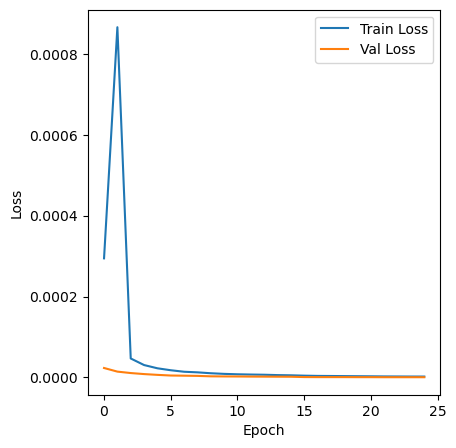

In [15]:

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

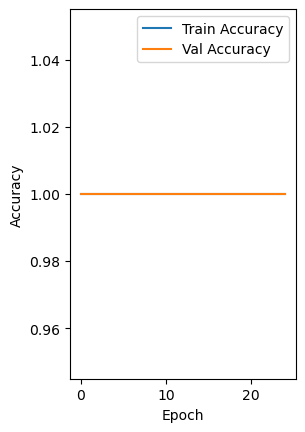

In [16]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# DEPLOYMENT

In [33]:
import random

def generate_text(seed_text, next_words, model, max_sequence_len, word_to_idx, idx_to_word):
    output_idx = [word_to_idx[word] for word in seed_text.split()]
    for _ in range(next_words):
        token_list = torch.tensor(output_idx).unsqueeze(0)
        with torch.no_grad():
            preds = model(token_list)
        # Sample from the probability distribution instead of selecting the most probable word
        next_word_idx = torch.multinomial(F.softmax(preds, dim=1), 1).item()
        output_idx.append(next_word_idx)
        if len(output_idx) >= max_sequence_len:
            break
        
    # Filter out padding index (0)
    output_words = [idx_to_word[idx] for idx in output_idx if idx != 0]
    generated_text = ' '.join(output_words)
    return generated_text

print(generate_text("How to", 6, model, max_seq_len, word_to_idx, idx_to_word))
print(generate_text("Amazing", 6, model, max_seq_len, word_to_idx, idx_to_word))


How to family TEACH ABSTRACT SCHOOL! USE RUSSIAN
Amazing trophy IGNORED What SNACK HOLIDAYS happened


In [35]:
print(generate_text("USEFUL", 6, model, max_seq_len, word_to_idx, idx_to_word))
print(generate_text("HELPFUL", 6, model, max_seq_len, word_to_idx, idx_to_word))

USEFUL 68 PRESERVE Tiny LIPS
HELPFUL OR Lazy NOTEBOOKS Learning RESTAURANT


# MODEL 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [3]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=64):
    try:
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    except Exception as e:
        print(f"An error occurred during training/evaluation: {str(e)}")


In [5]:
def preprocess_data(df):
    if df is None or 'abstract' not in df.columns or 'title' not in df.columns:
        print("Invalid dataset format. Expected 'abstract' and 'title' columns.")
        return None, None, None
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['abstract'])
    sequences = tokenizer.texts_to_sequences(df['abstract'])
    
    max_len = max(len(seq) for seq in sequences)
    X = pad_sequences(sequences, maxlen=max_len, padding='post')
    y = pad_sequences(tokenizer.texts_to_sequences(df['title']), maxlen=max_len, padding='post')
    
    vocab_size = len(tokenizer.word_index) + 1
    
    return X, y, vocab_size, max_len, tokenizer


In [6]:
def build_model(vocab_size, embedding_dim, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(units=vocab_size, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [1]:

def main():
    # Specify the path to the CSV file containing the dataset
    csv_file_path = 'papers.csv'

    # Load the dataset
    dataset = load_dataset(csv_file_path)

    if dataset is None:
        return

    # Preprocess the data
    X, y, vocab_size, max_len, tokenizer = preprocess_data(dataset)

    if X is None or y is None:
        return

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build the LSTM model
    embedding_dim = 100
    model = build_model(vocab_size, embedding_dim, max_len)

    # Train and evaluate the model
    train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=10)

if __name__ == "__main__":
    main()





Epoch 1/10


91/91 [==============================] - 463s 5s/step - loss: 2.6864 - accuracy: 0.9653
Epoch 2/10
91/91 [==============================] - 565s 6s/step - loss: 0.2324 - accuracy: 0.9775
Epoch 3/10
91/91 [==============================] - 649s 7s/step - loss: 0.2168 - accuracy: 0.9775
Epoch 4/10
91/91 [==============================] - 556s 6s/step - loss: 0.1883 - accuracy: 0.9776
Epoch 5/10
91/91 [==============================] - 637s 7s/step - loss: 0.1760 - accuracy: 0.9776
Epoch 6/10
91/91 [==============================] - 694s 7s/step - loss: 0.1709 - accuracy: 0.9777
Epoch 7/10
91/91 [==============================] - 787s 8s/step - loss: 0.1684 - accuracy: 0.9779
Epoch 8/10
91/91 [==============================] - 774s 8s/step - loss: 0.1662 - accuracy: 0.9779
Epoch 9/10
91/91 [==============================] - 665s 7s/step - loss: 0.1647 - accuracy: 0.9780
Epoch 10/10
46/46 [==============================] - 88s 2s/step - loss: 0.1706 - accuracy: 0.9778
Test 